In [14]:
from header import *

lr = 0.001
D = 2
import copy

model_f = nsp.model.UnitaryGenerator(D, dtype=torch.float64)
model_g = nsp.model.UnitaryGenerator(D, dtype=torch.complex128)
model_rf = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.float64)
model_rg = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.complex128)
model_sl = nsp.model.SlRiemanGenerator(D, dtype=torch.float64)
# set_seed(2022)

X = np.random.randn(D**2,D**2)
X = X.T + X 
# X = X_list[1]
loss = nsp.loss.L2(torch.Tensor(X), [D,D], matinv)

In [15]:
slcg = RiemanSlCG(model_sl, loss, lr = 0.1)

In [16]:
loss(model_sl.matrix()).backward()

In [17]:
model_sl.reset_params()
torch.linalg.det(model_sl.matrix())

tensor(-1.8574, dtype=torch.float64, grad_fn=<DetLuBasedHelperBackward0>)

In [18]:
model_sl.reset_params()
model_sl.matrix()

tensor([[ 0.0663,  0.6326],
        [-0.3200,  0.0023]], dtype=torch.float64, grad_fn=<ViewBackward0>)

In [10]:
torch.linalg.det(model_sl.matrix())

tensor(-11.8616, dtype=torch.float64, grad_fn=<DetLuBasedHelperBackward0>)

In [7]:
slcg._riemannian_grad(model_sl._params)

(tensor([[-3.7497e+12, -7.3609e+12],
         [ 2.3916e+12,  4.6951e+12]], dtype=torch.float64),
 tensor([[  8.5561, -18.0918],
         [ -5.9916,  11.2827]], dtype=torch.float64))

In [2]:
model = model_rg
model._params.data[:] = model._params.data[:].real
# model.reset_params()
solver = UnitarySymmTs(RiemanCG, model, loss, lr = 0.001, momentum=0.1, pout = True)
ret = solver.run(500, disable_message=False)
print(ret.model._params)

target loss      : 0.0000000000
initial loss     : 0.5642615937




  0%|          | 0/500 [00:00<?, ?it/s]

tensor([[ 0.0000+0.j, -0.6575+0.j],
        [ 0.6575+0.j,  0.0000+0.j]], dtype=torch.complex128)
tensor([[ 0.0000+0.j, -1.6198+0.j],
        [ 1.6198+0.j,  0.0000+0.j]], dtype=torch.complex128)
tensor([[ 0.0000+0.j, -3.9904+0.j],
        [ 3.9904+0.j,  0.0000+0.j]], dtype=torch.complex128)
tensor([[ 0.0000e+00+0.j, -3.4157e-07+0.j],
        [ 3.4157e-07+0.j,  0.0000e+00+0.j]], dtype=torch.complex128)
stack in local minimum --> break loop
Parameter containing:
tensor([-0.4638+0.j,  0.2745+0.j, -0.2737+0.j, -0.4601+0.j],
       dtype=torch.complex128, requires_grad=True)


In [153]:
model._params.grad

tensor([  88.5757+0.j,  -56.3448+0.j,  103.6056+0.j, -129.1369+0.j],
       dtype=torch.complex128)

In [41]:
X_list = []
D = 2
for _ in range(1000):
    X = np.random.randn(D**2,D**2)
    X = X.T + X
    loss = nsp.loss.L2(torch.Tensor(X), [D,D])    
    model_f = nsp.model.UnitaryGenerator(D, dtype=torch.float64)
    model_c = nsp.model.UnitaryGenerator(D, dtype=torch.complex128)

    bounds = [[-30, 30]] * model_f._n_params
    retf = scipy.optimize.dual_annealing(SymmSolver(model_f, loss, False), bounds = bounds, restart_temp_ratio = 1e-3,
                                  visit = 2.7, initial_temp = 10**4, maxiter = 200)

    bounds = [[-30, 30]] * model_c._n_params
    retc = scipy.optimize.dual_annealing(SymmSolver(model_c, loss, False), bounds = bounds, restart_temp_ratio = 1e-3,
                                  visit = 2.7, initial_temp = 10**4, maxiter = 200)

    if (retf.fun > retc.fun):
        X_list.append(X)

In [4]:
X_list = np.load("X_list.npy")

In [13]:
for X in X_list:
    loss = nsp.loss.L2(torch.Tensor(X), [D,D])    
    model_f = nsp.model.UnitaryGenerator(D, dtype=torch.float64)
    model_c = nsp.model.UnitaryGenerator(D, dtype=torch.complex128)

    bounds = [[-30, 30]] * model_f._n_params
    retf = scipy.optimize.dual_annealing(SymmSolver(model_f, loss, False), bounds = bounds, restart_temp_ratio = 1e-3,
                                  visit = 2.7, initial_temp = 10**4, maxiter = 200)

    bounds = [[-30, 30]] * model_c._n_params
    retc = scipy.optimize.dual_annealing(SymmSolver(model_c, loss, False), bounds = bounds, restart_temp_ratio = 1e-3,
                                  visit = 2.7, initial_temp = 10**4, maxiter = 200)
    print(retf.fun, retc.fun)

5.770925984678744 5.292979442869336
27.847899756439006 13.895719214599572
9.789390010988248 2.313756197872604
28.791250599565174 26.383543581852283
6.69481761216576 2.588452928564311
7.800129720637193 6.635604708698235
21.930120593746587 11.48976303839277
30.37899820061749 21.650105739625694
13.149980090020117 9.509583572453515


KeyboardInterrupt: 

(0.04376096578118228, 0.043760965781625895)

In [4]:
loss = nsp.loss.MES(torch.Tensor(X), [4])
loss_old = loss(ret.model.matrix()).item()
loss(ret.model.matrix()).backward()
W = ret.model.matrix().data
t = 0.001
res = []
for _ in range(1000):
    S_ = np.random.randn(4,4) + 1j*np.random.randn(4,4)
    S_ = S_ - S_.T
    S_ = torch.from_numpy(S_)
    S_ = S_/torch.linalg.norm(S_@W)
    loss_random = loss(torch.matrix_exp(-t*S_)@W)
    res.append((loss_random-loss_old).item())


AttributeError: model

In [17]:
from header import *

lr = 0.005
D = 2
model_sgd_0 = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.float64)
model_sgd_1 = copy.deepcopy(model_sgd_0)
model_sgd_2 = copy.deepcopy(model_sgd_0)
model_cg = copy.deepcopy(model_sgd_0)

model_lie = nsp.model.UnitaryGenerator(D, dtype=torch.float64)
bounds = [[-30, 30]] * model_lie._n_params

res = []
for _ in range(100):
    tmp = []
    X = np.random.randn(D**2,D**2)
    X = X.T + X
    loss = nsp.loss.L1(torch.Tensor(X), [D,D])
    solver = UnitarySymmTs(RiemanSGD, model_sgd_0, loss, lr = lr, momentum=0, pout = False)
    ret = solver.run(500, disable_message=True)
    tmp.append(ret["fun"])
    
    solver = UnitarySymmTs(RiemanSGD, model_sgd_1, loss, lr = lr, momentum=0.1, pout = False)
    ret = solver.run(500, disable_message=True)
    tmp.append(ret["fun"])

    solver = UnitarySymmTs(RiemanSGD, model_sgd_2, loss, lr = lr, momentum=0.5, pout = False)
    ret = solver.run(500, disable_message=True)
    tmp.append(ret["fun"])
    
    solver = UnitarySymmTs(RiemanCG, model_cg, loss, lr = lr, momentum=0, pout = False)
    ret = solver.run(500, disable_message=True)
    tmp.append(ret["fun"])
    
    ret = scipy.optimize.dual_annealing(SymmSolver(model_lie, loss, False), bounds = bounds, restart_temp_ratio = 1e-3,
                                  visit = 2.7, initial_temp = 10**4, maxiter = 200)
    tmp.append(ret.fun)
    res.append(tmp)

Failed save figure : given path exsist images/hist_annealing_vs_riemansgd_D=2_L=L1.jpeg


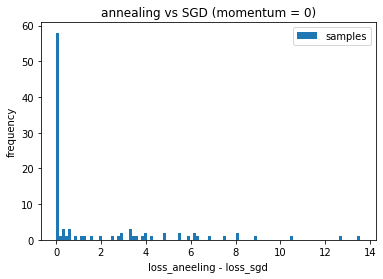

In [18]:
res = np.array(res)
fig, ax = plt.subplots()
res = np.array(res)
ax.hist(res[:,0] - res[:,-1], label="samples", bins=100)
ax.legend()


ax.set_title('annealing vs SGD (momentum = 0)')
ax.set_xlabel('loss_aneeling - loss_sgd')
ax.set_ylabel("frequency")
save_fig(plt, f'images/hist_annealing_vs_riemansgd_D={D}_L={type(loss).__name__}.jpeg', 400)
# plt.savefig(f'images/hist_sgd_vs_cg_D={D}_L={type(loss).__name__}.jpeg', dpi=400)

Failed save figure : given path exsist images/hist_annealing_vs_riemansgd1_D=2_L=L1.jpeg


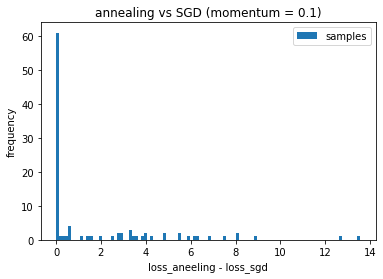

In [19]:
res = np.array(res)
fig, ax = plt.subplots()
res = np.array(res)
ax.hist(res[:,1] - res[:,-1], label="samples", bins=100)
ax.legend()


ax.set_title('annealing vs SGD (momentum = 0.1)')
ax.set_xlabel('loss_aneeling - loss_sgd')
ax.set_ylabel("frequency")
save_fig(plt, f'images/hist_annealing_vs_riemansgd1_D={D}_L={type(loss).__name__}.jpeg', 400)
# plt.savefig(f'images/hist_sgd_vs_cg_D={D}_L={type(loss).__name__}.jpeg', dpi=400)

Failed save figure : given path exsist images/hist_annealing_vs_riemansgd2_D=2_L=L1.jpeg


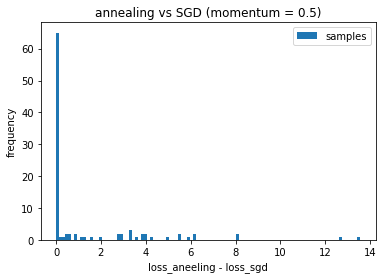

In [20]:
res = np.array(res)
fig, ax = plt.subplots()
res = np.array(res)
ax.hist(res[:,2] - res[:,-1], label="samples", bins=100)
ax.legend()


ax.set_title('annealing vs SGD (momentum = 0.5)')
ax.set_xlabel('loss_aneeling - loss_sgd')
ax.set_ylabel("frequency")
save_fig(plt, f'images/hist_annealing_vs_riemansgd2_D={D}_L={type(loss).__name__}.jpeg', 400)
# plt.savefig(f'images/hist_sgd_vs_cg_D={D}_L={type(loss).__name__}.jpeg', dpi=400)

Failed save figure : given path exsist images/hist_annealing_vs_cg_D=2_L=L1.jpeg


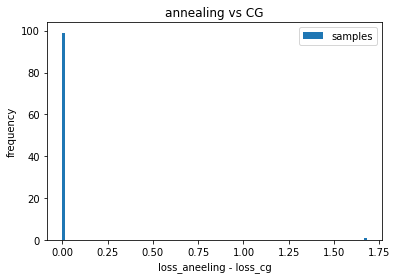

In [21]:
res = np.array(res)
fig, ax = plt.subplots()
res = np.array(res)
ax.hist(res[:,3] - res[:,-1], label="samples", bins=100)
ax.legend()


ax.set_title('annealing vs CG')
ax.set_xlabel('loss_aneeling - loss_cg')
ax.set_ylabel("frequency")
save_fig(plt, f'images/hist_annealing_vs_cg_D={D}_L={type(loss).__name__}.jpeg', 400)
# plt.savefig(f'images/hist_sgd_vs_cg_D={D}_L={type(loss).__name__}.jpeg', dpi=400)

In [27]:
import datetime

dt = datetime.datetime.today()  # ローカルな現在の日付と時刻を取得
"_".join(str(dt).split(" "))

'2022-07-05_06:00:59.753909'

In [54]:
from header import *
D = 3
X = np.random.randn(D**2, D**2)
X = (X + X.T)/2
mask = X>=(1/(D**2))
X[mask] = 0
E0 = np.linalg.eigvalsh(X)[0]

In [55]:
Loss = nsp.loss.MES(torch.Tensor(X), [D,D]) 
Y = Loss.X.data
np.linalg.eigvalsh(np.abs(Y))

array([0.55854976, 0.81605303, 1.2024018 , 2.0357444 , 2.272951  ,
       2.5335343 , 2.8768919 , 3.1520739 , 4.228941  ], dtype=float32)

In [94]:
Y = np.array(Loss.X.data)
E, V = np.linalg.eigh(Y) 
Ea, Va = np.linalg.eigh(np.abs(Y))

In [111]:
isinstance([3,4], list)

True

In [110]:
list(model_rf.parameters())

[Parameter containing:
 tensor([-0.9848,  0.0112,  0.1731,  0.1183, -0.6867,  0.7172,  0.1269,  0.7268,
          0.6750], dtype=torch.float64, requires_grad=True)]

In [107]:
np.abs(Y)-Y

array([[0.        , 0.        , 1.5164971 , 0.        , 0.993344  ,
        0.        , 0.        , 0.93901885, 1.1813904 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.15686078, 0.        , 0.39691994, 0.        ],
       [1.5164971 , 0.        , 0.        , 0.47393334, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.47393334, 0.        , 0.        ,
        0.        , 2.038791  , 0.15622143, 1.0123354 ],
       [0.993344  , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.47028244, 0.05242529, 1.8916839 ],
       [0.        , 0.15686078, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.4775648 ],
       [0.        , 0.        , 0.        , 2.038791  , 0.47028244,
        0.        , 0.        , 1.5282452 , 0.5946963 ],
       [0.93901885, 0.39691994, 0.        , 0.15622143, 0.05242529,
        0.        , 1.5282452 , 0.        , 0.        ],


In [106]:
Va[:,-1] @ (np.abs(Y)-Y) @ Va[:,-1] 

3.8970418

In [105]:
V[:,-1] @ (np.abs(Y)-Y) @ V[:,-1]

-2.716371

In [82]:
from header import *

lr = 0.001


import copy

model_rf = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.float64)
model_rg = nsp.model.UnitaryRiemanGenerator(D, dtype=torch.complex128)

model_rf.set_params(torch.eye(model_rf.matrix().shape[0]).view(-1))

print(Loss(model_rf.matrix()))

model_rg.reset_params()
model_rf.reset_params()

# set_seed(333)

res = []
# X_list = np.load("X_list.npy")
# for X in X_list[:3]:
sparse = 1/D


tmp = []


solver = UnitarySymmTs(RiemanUnitaryCG, model_rf, Loss, pout = True)
ret = solver.run(500, disable_message=False)


tensor(4.2289, grad_fn=<SelectBackward0>)
target loss      : 3.7395293713
initial loss     : 4.5095285735




  0%|          | 0/500 [00:00<?, ?it/s]

No local minimum found
-1.543498226630309e-11 3.6358858778839926e-15 4.103038151877053 4.103038151855147
stack in local minimum --> break loop


In [52]:
model = model_rg
cg = RiemanUnitaryCG(model, Loss, 0.001)
Loss(model.matrix()).backward()
S, W = cg._riemannian_grad(model._params)

W = W.detach()
S = S.detach()
def objective(t):
    return Loss(torch.matrix_exp(-t*S)@W).item()

delta = 0.01
t = torch.tensor([0.], requires_grad=True)
Loss(torch.matrix_exp(-t*S)@W).backward()
step = abs(objective(0) / t.grad.item() * delta)

In [53]:
lr = cg._golden(W.detach(),S.detach())
# print(objective(0), objective(step), objective(step*10))
# step *= 10

0.00037100838988031817


In [54]:
from scipy.optimize import minimize_scalar

# lr = scipy.optimize.golden(objective, brack=(0, step, step*10))
print(lr, objective(lr))

0.00037100838988031817 164.72608349107475


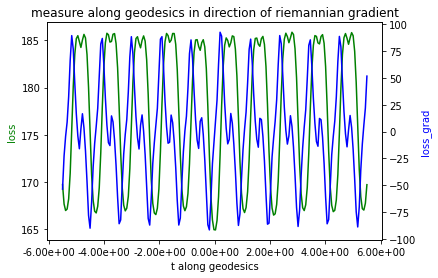

In [55]:
from header import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# loss_l2 = nsp.loss.L2(X, [D,D])
# loss_mes = nsp.loss.MES(X, [D,D])
t = 0.001
ret_min_grad = 1e10



res_grad = []
res = []
# step = step*10
x = np.linspace(-10*abs(step), 10*abs(step), 200)
for t_ in x:
    t =  torch.tensor([t_], requires_grad=True, dtype=torch.float64)
    U = torch.matrix_exp(-t*S)@W
    loss = Loss(U)
    g = torch.autograd.grad(loss, t, create_graph=True)
    res.append(loss.item())
    res_grad.append(g[0].item())   

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_title('measure along geodesics in direction of riemannian gradient')
ax1.set_xlabel('t along geodesics')
ax1.set_ylabel('loss', color='g')
ax2.set_ylabel('loss_grad', color='b')
ax1.plot(x, res, color="g")
ax2.plot(x, res_grad, color="b")
current_values = plt.gca().get_yticks()
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
fig.show()

1.9093e-05


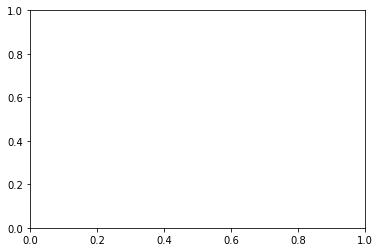

In [11]:
current_values = plt.gca().get_yticks()
print("{:.4e}".format(lr))

In [75]:
# cg._golden(W.detach(),S.detach())


In [80]:
f = Loss(torch.matrix_exp(-t*S)@W)
g = torch.autograd.grad(f, t, create_graph=True)
g2 = torch.autograd.grad(g, t, create_graph=True)

In [88]:
with torch.no_grad():
    step = (g[0] / g2[0]) * 0.01

In [89]:
step

tensor([-6.1564e-05])

In [72]:
t.grad.item()

-2.3202754821649574e-12

In [67]:
t.grad.item()

-1.963310156810616e-12

In [66]:
objective(0)

1.9120745386919595

In [32]:
step

-2.9657366812972122e-06

In [41]:
objective(0), objective(step), objective(step*10)

(22622.053375366908, 22428.084411819087, 23502.480540665827)

In [42]:
from scipy.optimize import minimize_scalar

scipy.optimize.golden(objective, brack=(0, step, step*10))


1.2291359954038044e-05

In [52]:
objective(step/delta)

31163.407361635935